**Sale Price prediction**

Predicting House Prices with classical Linear Regression approach. The project focuses on data cleaning and feature engineering. ANOVA, Breusch-Pagan-Test and transformation techniques for skewed features are explored to find a linear regression model with minimum RMSE. 

In [313]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import f_oneway
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from scipy.stats import skewtest

In [314]:
data = pd.read_csv("AmesHousing.csv")
data.shape

(2930, 82)

In [315]:
data.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

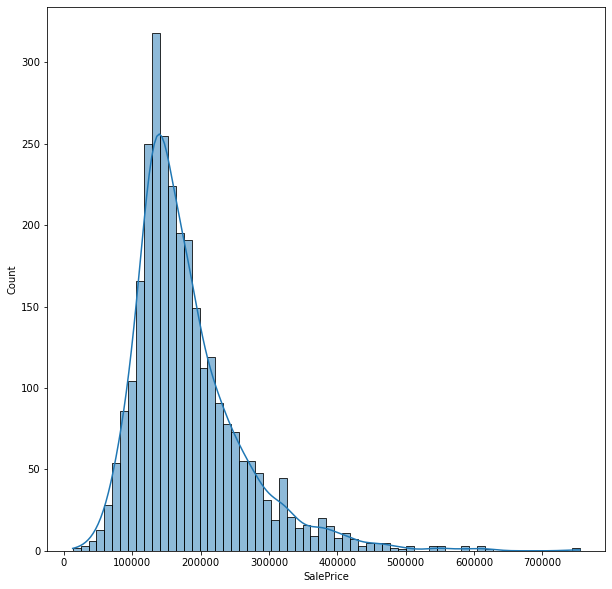

In [316]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sns.histplot(data.SalePrice, kde = True, ax = ax)
plt.show()

**Data Cleaning and Manipulation**

In [317]:
# Columns with missing values
null_values = data.isnull().sum()
print(null_values[null_values > 0])

Lot Frontage       490
Alley             2732
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64


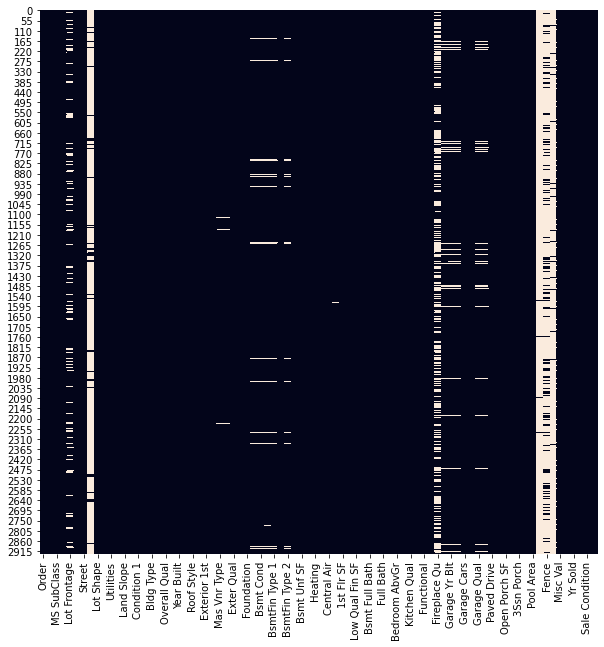

In [318]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(data.isnull(), cbar = False, ax=ax)
plt.show()

In [319]:
# take a look at Misc Features
print(data["Misc Feature"].value_counts())

#Shed is transfromed in dummy varible, Misc is droped 

data["shed"] = [1 if i == "Shed" else 0 for i in data["Misc Feature"]]
data.drop("Misc Feature", axis = 1, inplace = True)

Shed    95
Gar2     5
Othr     4
TenC     1
Elev     1
Name: Misc Feature, dtype: int64


In [320]:
# All missing values in "Fireplaces" corresspond to no fireplace
# NA is replaced with 0
data["Fireplace Qu"].fillna(0, inplace = True)

In [321]:
# Set has 2930 observations. Some features have more than 95% missing values. 
# Those feature are droped
# Some additional information about garages are lost. But that should not be too crucial. 
# Other informations are already incorperated in other features e.g. lot frontage in lot size 
null_values = (data.isnull().sum())/data.shape[0]
to_drop = null_values[null_values > 0.05].index
data.drop(to_drop, axis = 1, inplace = True)

In [322]:
# all numercial column na`s are filled with the mode of that column
data.loc[:,data.dtypes != "object"] = data.loc[:,data.dtypes != "object"].fillna(data.mode().iloc[0])

In [323]:
# categorial features are droped if one value is missing
# Some informations about the basement is lost
# except for the column "Electrical", which only has one missing entry

data["Electrical"] = data["Electrical"].fillna(data.Electrical.mode().iloc[0])

categorial_col = data.dtypes[data.dtypes == "object"]
cat_na = data[categorial_col.index].isnull().sum()
to_drop = cat_na[cat_na > 0].index
data.drop(to_drop, axis = 1, inplace = True)

In [324]:
# no missing values left
data.isnull().sum().sum()

0

In [325]:
# Adding a new feature: Age of House when sold
# "Year Remod/Add" is equal to "Year Built" if no Remod/Add occured
data["Age"] = data["Yr Sold"] - data["Year Remod/Add"]

In [326]:
# There are two negavtive values in the age column
# Those observations are dropped
print(data.Age.value_counts().sort_values(ascending=True)[0:3])
data = data.loc[data.Age >= 0,:]

-2      1
-1      2
 24    10
Name: Age, dtype: int64


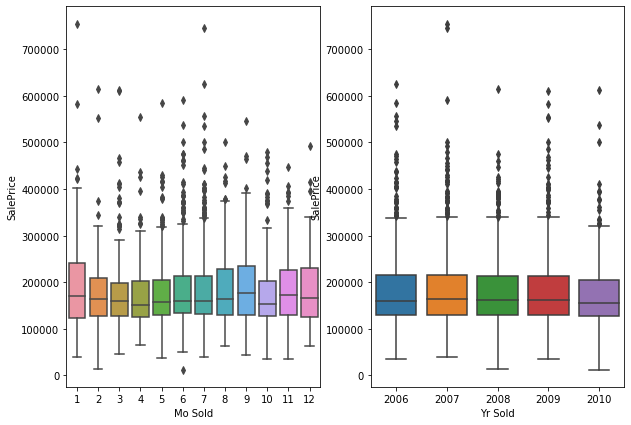

In [328]:
#Does the Price depend on month or year?
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,7))

sns.boxplot(x = data["Mo Sold"], y = data.SalePrice, ax = ax1)
sns.boxplot(x = data["Yr Sold"], y = data.SalePrice, ax = ax2)

plt.show()

# Neither month or year seem to have an effect an the price

In [329]:
#ANOVA is used to quantify that impression

group_month = data.groupby("Mo Sold")
month_df = [group_month.get_group(i).SalePrice for i in group_month.groups.keys()]
f_stat_month, p_val_month = f_oneway(*month_df)

group_year = data.groupby("Yr Sold")
year_df = [group_year.get_group(i).SalePrice for i in group_year.groups.keys()]
f_stat_year, p_val_year = f_oneway(*year_df)

print("The monthly mean prices are not different from each other, since the p-value is {}."
      .format(round(p_val_month,4)))
print("The yearly mean prices are not different from each other, since the p-value is {}."
      .format(round(p_val_year,4)))

The monthly mean prices are not different from each other, since the p-value is 0.1313.
The yearly mean prices are not different from each other, since the p-value is 0.1968.


In [260]:
# dropping unnecessary columns

data.drop(["PID","Order","Sale Type","Yr Sold","Mo Sold", "Year Remod/Add","Year Built", "Sale Condition"],
          axis = 1, inplace = True)

In [261]:
#Transformation from categories into dummy varibles

data["Paved Drive"] = pd.get_dummies(data["Paved Drive"]).Y

cats = data.dtypes[data.dtypes == "object"]

for col in cats.index:
    print(col,":", len(data[col].value_counts()))

MS Zoning : 7
Street : 2
Lot Shape : 4
Land Contour : 4
Utilities : 3
Lot Config : 5
Land Slope : 3
Neighborhood : 28
Condition 1 : 9
Condition 2 : 8
Bldg Type : 5
House Style : 8
Roof Style : 6
Roof Matl : 8
Exterior 1st : 16
Exterior 2nd : 17
Exter Qual : 4
Exter Cond : 5
Foundation : 6
Heating : 6
Heating QC : 5
Central Air : 2
Electrical : 5
Kitchen Qual : 5
Functional : 8
Fireplace Qu : 6


In [262]:
#olumns with less than 10 categories are transfromed into dummies

dummies_df = pd.DataFrame()
less_than_10 = [index for index in cats.index if len(data[index].value_counts()) < 10]
more_than_10 = [index for index in cats.index if len(data[index].value_counts()) >= 10]

for col in less_than_10:
    df = pd.get_dummies(data[col], drop_first = True, prefix = col)
    dummies_df = pd.concat([dummies_df,df], axis = 1)

In [263]:
# Replace original columns

data.drop(less_than_10, axis = 1, inplace = True)
data = pd.concat([data,dummies_df], axis = 1)

In [264]:
# Columns with more than 10 categories

print(more_than_10)

['Neighborhood', 'Exterior 1st', 'Exterior 2nd']


In [265]:
# One way would be to tranform all of the unique values to dummy columns
# But since there are a lot of unique values and there are already 100+ features, only the most relevant
# are kept. 
# TurkeyHSD is used to determine the values with a mean price different to most others.
# Those are trnaformed to dummy columns, the others are dropt

def get_specific_dummies(col, count):
    
    # taking columns and a maximum number of values sorted by relevance
    global data
    
    turkey = pairwise_tukeyhsd(endog = data.SalePrice,
                 groups = data[col])
    turkey_df = pd.DataFrame(turkey.summary(), dtype = str)
    turkey_df.columns = turkey_df.loc[0,:]
    turkey_df.drop(0, inplace = True)
    turkey_df["reject"] = turkey_df["reject"].apply(lambda x: True if x == "True" else False)
    
    all_values = data[col].value_counts().index
    difference_counts = {}
    
    for value in all_values:
        selected_df = turkey_df.loc[((turkey_df.group1) == value) | (turkey_df.group2 == value),:]
        difference_counts[value] = selected_df.reject.sum()

    most_diff = sorted(difference_counts.items(), key = lambda x: x[1], reverse = True)
    keep_values = [col + "_" + i[0] for i in most_diff[0:count]]
    
    # replacing original columns with dummies 
    
    dummies = pd.get_dummies(data[col], prefix = col)
    data = pd.concat([data,dummies[keep_values]], axis = 1)
    data.drop(col, axis = 1, inplace = True)
    
    return(most_diff)

In [266]:
get_specific_dummies("Neighborhood", 5)

[('NridgHt', 23),
 ('NoRidge', 23),
 ('StoneBr', 23),
 ('Timber', 22),
 ('Somerst', 19),
 ('IDOTRR', 19),
 ('Veenker', 19),
 ('Mitchel', 18),
 ('MeadowV', 18),
 ('NAmes', 17),
 ('CollgCr', 17),
 ('Gilbert', 17),
 ('Sawyer', 17),
 ('NWAmes', 17),
 ('BrDale', 17),
 ('OldTown', 16),
 ('Edwards', 16),
 ('SawyerW', 15),
 ('BrkSide', 15),
 ('Crawfor', 15),
 ('ClearCr', 15),
 ('SWISU', 14),
 ('Blmngtn', 14),
 ('NPkVill', 12),
 ('GrnHill', 8),
 ('Blueste', 6),
 ('Greens', 6),
 ('Landmrk', 0)]

In [267]:
get_specific_dummies("Exterior 1st", 3)

[('VinylSd', 8),
 ('CemntBd', 8),
 ('AsbShng', 8),
 ('Wd Sdng', 5),
 ('BrkFace', 5),
 ('MetalSd', 4),
 ('Plywood', 4),
 ('HdBoard', 3),
 ('WdShing', 3),
 ('Stucco', 2),
 ('BrkComm', 0),
 ('Stone', 0),
 ('AsphShn', 0),
 ('CBlock', 0),
 ('ImStucc', 0),
 ('PreCast', 0)]

In [268]:
get_specific_dummies("Exterior 2nd", 3)

[('CmentBd', 9),
 ('VinylSd', 8),
 ('ImStucc', 8),
 ('AsbShng', 7),
 ('MetalSd', 4),
 ('HdBoard', 4),
 ('Wd Sdng', 4),
 ('Plywood', 4),
 ('Wd Shng', 3),
 ('Stucco', 3),
 ('BrkFace', 3),
 ('Brk Cmn', 3),
 ('Stone', 0),
 ('AsphShn', 0),
 ('CBlock', 0),
 ('Other', 0),
 ('PreCast', 0)]

In [269]:
# Overall Condition and Overall Qualiity are numercial columns bet should be tranformed into
# dummy columns as well.

for col in ["Overall Qual", "Overall Cond"]:
    df = pd.get_dummies(data[col], drop_first = True, prefix = col)
    data = pd.concat([data,df], axis = 1)

data.drop(["Overall Qual", "Overall Cond"], axis = 1, inplace = True)

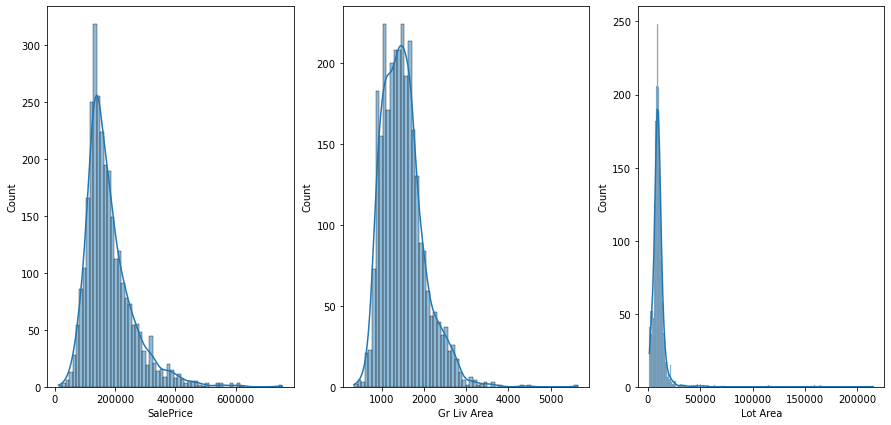

In [270]:
# Some of the features and even "SalePrice" are heavily skewed.

fig , (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,7))

sns.histplot(data.SalePrice, kde = True, ax = ax1)
sns.histplot(data["Gr Liv Area"], kde = True, ax = ax2)
sns.histplot(data["Lot Area"], kde = True, ax = ax3)
plt.show()

In [271]:
# Therefore, a log transformation is applied to all skewed numeric columns

for col in data.columns:
    
    if len(data[col].value_counts()) > 10:
        statistic , pval = skewtest(data[col])
        if pval < 0.05:  
            data[col] = np.log1p(data[col]) # Because 0 values exist, transformation ln(1+x) is used

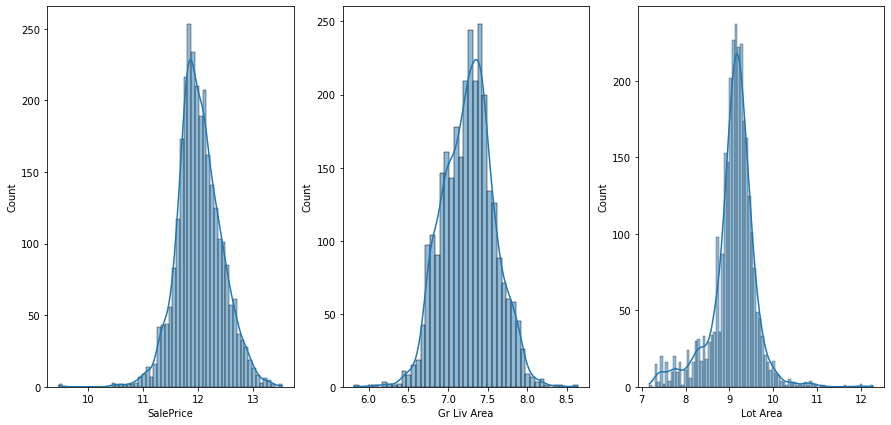

In [272]:
# Same features from last plot with transformation applied

fig , (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,7))

sns.histplot(data.SalePrice, kde = True, ax = ax1)
sns.histplot(data["Gr Liv Area"], kde = True, ax = ax2)
sns.histplot(data["Lot Area"], kde = True, ax = ax3)
plt.show()

**Analysis**

In [273]:
# Linear Regressions with 150+ features are likley to overfit.
# Selecting features based on Correlation with "SalePrice" beforehand.

corr = data.corr()
price_corr = np.abs(corr.SalePrice)
highest_corr = price_corr.sort_values(ascending = False).drop("SalePrice")
print(highest_corr[:20])

Gr Liv Area             0.725987
Garage Cars             0.675652
1st Flr SF              0.616081
Exter Qual_TA           0.586299
Full Bath               0.577660
Age                     0.565437
Foundation_PConc        0.544150
Kitchen Qual_TA         0.535927
TotRms AbvGrd           0.502310
Exter Qual_Gd           0.500020
Fireplaces              0.489041
Open Porch SF           0.462615
Garage Area             0.439228
Mas Vnr Area            0.434863
Overall Qual_8          0.418348
Kitchen Qual_Gd         0.386543
Total Bsmt SF           0.379908
Overall Cond_5          0.375178
Neighborhood_NridgHt    0.371339
Central Air_Y           0.370113
Name: SalePrice, dtype: float64


In [274]:
# Testing model performance based on different values of p. 

In [296]:
# for better interpretation of RMSE, Predictions can be tranfromed back to original Scale

def crossvalidation(estimator, k=5 , scale_back = False):
    # Returns Root Mean Squared Error for every Fold
    all_rmse = []
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        lm = estimator
        lm.fit(train[features],train["SalePrice"]) #features defined in 50-50 testing
        predictions = lm.predict(test[features])
        
        # for better interpretation of RMSE, Predictions are tranfromed back to original Scale
        
        if scale_back == True:
            
            mse = mean_squared_error(np.expm1(predictions), np.expm1(test["SalePrice"]))
            all_rmse.append(mse**0.5)
            
        else: 
            
            mse = mean_squared_error(predictions, test["SalePrice"])
            all_rmse.append(mse**0.5)
    
    return all_rmse

In [297]:
all_rmse = pd.Series(dtype = "float64")

for i in range(0,52,2):
    features = highest_corr[highest_corr > i/100].index
    all_rmse[str(i/100)] = np.mean(crossvalidation(LinearRegression(), scale_back = True))
    
all_rmse.sort_values()

0.08    24824.157965
0.1     25004.555872
0.06    25146.633727
0.04    25175.651524
0.0     25261.281343
0.12    25338.768928
0.02    25405.711097
0.14    25910.307361
0.16    26100.558714
0.18    26500.652294
0.2     27014.780474
0.22    27871.160923
0.24    28104.921862
0.26    30549.976275
0.3     31155.768786
0.34    31231.403260
0.32    31247.265209
0.28    31263.883506
0.36    31565.727714
0.38    34559.044760
0.42    35019.702739
0.4     35055.680118
0.48    35113.472656
0.44    35120.893410
0.46    35120.893410
0.5     36130.538076
dtype: float64

In [298]:
# every feature with a higher correlation than 0.1 is taken into account

features = highest_corr[highest_corr > 0.1].index

In [299]:
# fitting suggested Modell

train_x, test_x, train_y, test_y = train_test_split(data.drop("SalePrice", axis = 1)
                                                    ,data.SalePrice , test_size=0.2, random_state=5)

lm = sm.OLS(endog = train_y, exog = sm.add_constant(train_x[features]))
reg = lm.fit()

In [300]:
# Test for heteroskedasticity
# BP pvalue is lower than 0.05, heteroskedasticity is assumed and HC1 is used. 

sm.stats.diagnostic.het_breuschpagan(reg.resid, sm.add_constant(train_x[features]))

(336.9977307874623,
 1.02941334560813e-31,
 4.4612482237084246,
 5.32667629500677e-35)

In [301]:
# Calculate p-values with robust STD err.
reg = lm.fit(cov_type = "HC1",use_t =True)
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     340.8
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:44:52   Log-Likelihood:                 1614.8
No. Observations:                2341   AIC:                            -3058.
Df Residuals:                    2255   BIC:                            -2562.
Df Model:                          85                                         
Covariance Type:                  HC1                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    7.7743      0.216     36.070      0.000       7.352       8.197
Gr Liv Area              0.4256      0.048      8.960      0.000       0.332       0.519
Garage Cars              0.0406      0.009      4.646      0.000       0.023       0.058
1st Flr SF               0.0232      0.051      0.457      0.648      -0.076       0.123
Exter Qual_TA           -0.0511      0.023     -2.196      0.028      -0.097      -0.005
Full Bath                0.0516      0.008      6.275      0.000       0.035       0.068
Age                     -0.0251      0.004     -6.095      0.000      -0.033      -0.017
Foundation_PConc         0.0643      0.013      4.863      0.000       0.038       0.090
Kitchen Qual_TA         -0.0777      0.015     -5.098      0.000      -0.108      -0.048
TotRms AbvGrd           -0.0099      0.026     -0.376      0.707      -0.061       0.042
Exter Qual_Gd           -0.0342      0.022     -1.534      0.125      -0.078       0.010
Fireplaces               0.0348      0.010      3.474      0.001       0.015       0.054
Open Porch SF            0.0020      0.002      1.332      0.183      -0.001       0.005
Garage Area              0.0041      0.004      1.021      0.308      -0.004       0.012
Mas Vnr Area         -6.494e-05      0.001     -0.058      0.954      -0.002       0.002
Overall Qual_8           0.1414      0.011     12.546      0.000       0.119       0.164
Kitchen Qual_Gd         -0.0553      0.014     -4.012      0.000      -0.082      -0.028
Total Bsmt SF            0.0174      0.006      2.955      0.003       0.006       0.029
Overall Cond_5          -0.0551      0.018     -3.084      0.002      -0.090      -0.020
Neighborhood_NridgHt     0.0733      0.021      3.426      0.001       0.031       0.115
Central Air_Y            0.0498      0.020      2.501      0.012       0.011       0.089
Overall Qual_9           0.2372      0.025      9.525      0.000       0.188       0.286
Lot Area                 0.0744      0.010      7.758      0.000       0.056       0.093
Exterior 1st_VinylSd     0.0008      0.026      0.030      0.976      -0.051       0.053
Fireplace Qu_Gd         -0.0032      0.014     -0.230      0.818      -0.030       0.024
Paved Drive              0.0383      0.013      2.865      0.004       0.012       0.065
Heating QC_TA           -0.0342      0.008     -4.446      0.000      -0.049      -0.019
Exterior 2nd_VinylSd     0.0025      0.027      0.092      0.927      -0.051       0.056
Overall Qual_5          -0.0423      0.008     -5.619      0.000      -0.057      -0.028
Wood Deck SF             0.0033      0.001      3.170      0.002       0.001       0.005
MS Zoning_RM            -0.0114      0.031     -0.370      0.712      -0.072       0.049
Overall Qual_4          -0.1091      0.015     -7.244    

In [302]:
# Some features have pvalues way above 0.05
# The feature with the highest pvalue will be removed and the model recalculated
# Procedure stops when all pvalues are below 0.05

p_values = reg.pvalues.drop("const")

while max(p_values) > 0.05:
    highest_p = reg.pvalues.sort_values(ascending=False).index[0]
    features = features.drop(highest_p)
    reg = sm.OLS(endog = train_y, exog =  sm.add_constant(train_x[features]))
    reg = reg.fit(cov_type = "HC3")
    p_values = reg.pvalues.drop("const")

In [303]:
# Summary of reduced Model

reg = sm.OLS(endog = train_y, exog =  sm.add_constant(train_x[features])).fit(cov_type = "HC1")
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     527.4
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:45:06   Log-Likelihood:                 1498.6
No. Observations:                2341   AIC:                            -2899.
Df Residuals:                    2292   BIC:                            -2617.
Df Model:                          48                                         
Covariance Type:                  HC1                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    7.6227      0.206     36.993      0.000       7.219       8.027
Gr Liv Area              0.4666      0.028     16.781      0.000       0.412       0.521
Garage Cars              0.0449      0.007      6.085      0.000       0.030       0.059
Full Bath                0.0477      0.008      5.813      0.000       0.032       0.064
Age                     -0.0280      0.004     -7.719      0.000      -0.035      -0.021
Foundation_PConc         0.0616      0.012      4.945      0.000       0.037       0.086
Kitchen Qual_TA         -0.0904      0.015     -6.137      0.000      -0.119      -0.062
Fireplaces               0.0331      0.006      5.947      0.000       0.022       0.044
Overall Qual_8           0.1488      0.011     13.517      0.000       0.127       0.170
Kitchen Qual_Gd         -0.0615      0.014     -4.525      0.000      -0.088      -0.035
Total Bsmt SF            0.0169      0.006      2.842      0.004       0.005       0.029
Overall Cond_5          -0.0595      0.010     -5.971      0.000      -0.079      -0.040
Neighborhood_NridgHt     0.0717      0.017      4.105      0.000       0.037       0.106
Central Air_Y            0.0596      0.020      3.056      0.002       0.021       0.098
Overall Qual_9           0.2530      0.024     10.741      0.000       0.207       0.299
Lot Area                 0.0735      0.010      7.721      0.000       0.055       0.092
Paved Drive              0.0482      0.014      3.426      0.001       0.021       0.076
Heating QC_TA           -0.0266      0.007     -3.607      0.000      -0.041      -0.012
Overall Qual_5          -0.0372      0.009     -3.932      0.000      -0.056      -0.019
Wood Deck SF             0.0030      0.001      2.931      0.003       0.001       0.005
Overall Qual_4          -0.1104      0.019     -5.728      0.000      -0.148      -0.073
Foundation_CBlock        0.0288      0.012      2.376      0.018       0.005       0.053
Half Bath                0.0268      0.008      3.398      0.001       0.011       0.042
MS Zoning_RL             0.0627      0.012      5.052      0.000       0.038       0.087
Bsmt Full Bath           0.0292      0.007      4.133      0.000       0.015       0.043
Neighborhood_NoRidge     0.0944      0.018      5.394      0.000       0.060       0.129
BsmtFin SF 1             0.0098      0.001      7.878      0.000       0.007       0.012
Overall Qual_10          0.2978      0.079      3.754      0.000       0.142       0.453
Overall Qual_7           0.0662      0.008      8.735      0.000       0.051       0.081
Overall Qual_3          -0.1743      0.047     -3.691      0.000      -0.267      -0.082
Kitchen Qual_Fa         -0.1422      0.041     -3.477      0.001      -0.222      -0.062
Overall Cond_3          -0.1926      0.039     -5.003    

In [305]:
# RMSE score of reduced Model

predictions = reg.predict(sm.add_constant(test_x[features]))
np.mean(crossvalidation(LinearRegression(), scale_back = True))

24317.616951801472

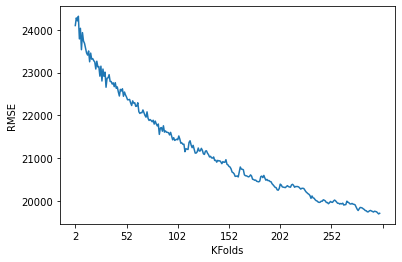

In [311]:
# Development of RMSE with rising k.

RMSE = pd.Series(dtype = "float64")

for i in range(2,300):
    RMSE[str(i)] = np.mean(crossvalidation(LinearRegression(), k = i, scale_back = True ))
    
RMSE.plot()
plt.xlabel("KFolds")
plt.ylabel("RMSE")
plt.show()

In [307]:
reg.params.sort_values(ascending = False)

const                   7.622678
Gr Liv Area             0.466629
Overall Qual_10         0.297757
Overall Qual_9          0.252967
Overall Qual_8          0.148772
Functional_Typ          0.100428
Neighborhood_NoRidge    0.094411
Neighborhood_StoneBr    0.078657
Lot Area                0.073470
MS Zoning_FV            0.072006
Neighborhood_NridgHt    0.071747
Overall Qual_7          0.066201
MS Zoning_RL            0.062743
Foundation_PConc        0.061558
Land Contour_HLS        0.060230
Central Air_Y           0.059597
Neighborhood_Somerst    0.053819
Condition 1_Norm        0.050047
Paved Drive             0.048198
Full Bath               0.047717
Garage Cars             0.044901
Fireplaces              0.033118
Lot Config_CulDSac      0.029324
Bsmt Full Bath          0.029229
Foundation_CBlock       0.028814
Half Bath               0.026837
Total Bsmt SF           0.016941
BsmtFin SF 1            0.009759
Screen Porch            0.008767
Wood Deck SF            0.003041
Bsmt Unf S

**Summary**

Using the above specified regression, one can aspect the prediction to be off by about 20 000 USD. The results get significantly better when the logarithmic transformation is applied.

Unsurprisingly, neighborhood/location and quality scores are found to be the biggest price drivers of Houses in Ames. The quality of the kitchen also turns out to be essential for the price.

Apart from the more obvious influencing factors such as living space and plot size, the number of fireplaces and the type of foundation contain valuable information about the house value.